In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

### Dataframe Building
From the exploratory data analysis I know that I need to remove the observations where the salary is equal to 0.

In [2]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test_features.csv')

In [3]:
train.shape

(1000000, 10)

In [4]:
clean_df = train[train.salary > 0]
clean_df = clean_df.drop('jobId', axis = 1)
clean_df.shape

(999995, 9)

In [5]:
feature_df = clean_df.drop('salary',axis = 1)
target = clean_df['salary']
job_id = test['jobId']
test = test.drop('jobId', axis = 1)

#### Building a ColumnTransformer
To one hot encode or label encode a dataframe multiple lines of code were needed and thus, the birth of the column transformer. Instead of needing multiple lines of code, the column transformer does it with one.

Using the column transformer, I will one hot encode the categorical variables and pass through the numerical features(do nothing to but keep with attached to the categorical features).

I also did one hot encoding without the column transformer as I needed a dataframe for finding the mean absolute error for a baseline model.

In [6]:
transformer = make_column_transformer(
(OneHotEncoder(), ['companyId','jobType',
            'degree','major','industry']),
            remainder = 'passthrough')

In [7]:
dummies = pd.get_dummies(feature_df, columns = ['companyId','jobType','degree','major','industry'])
dum = dummies.loc[:, ~dummies.columns.str.match('Unnamed')]
print(F"There are {len(dum.columns)} features after one hot encoding.")

There are 94 features after one hot encoding.


#### Baseline Model

A baseline model should be simple and easy to interpret. My baseline model just predicts a constant value (50k, 100k average, 150k & 200k) for a salary and finds the mean absolute error. Easy and simple. We can use this information to understand how much better running a ML model is compared to a constant prediction.

In [8]:
avg = np.mean(target)
print(F"The average salary is ${avg:.2f}k")
print()
constant = [50,100,int(avg),150,200]
for con in constant:
    lst = [con]*len(target)
    mae = mean_absolute_error(target, lst)
    print(F"The MAE predicting only ${con}k is {mae:.5f}")

The average salary is $116.06k

The MAE predicting only $50k is 66.61364
The MAE predicting only $100k is 32.91118
The MAE predicting only $116k is 31.00767
The MAE predicting only $150k is 43.14076
The MAE predicting only $200k is 84.69683


The best baseline model is to use the average salary of the target. The MAE is 31, meaning that a predicted salary of 116k is off by 31k. However, we are not sure if its 31k below or above the correct salary to offer. This should be pretty intuitive. 

### Linear Regression

The first model is linear regression. I first run a model to see how well it performs then I use SelectKBest's F-regressor to test the individual effect of each of many regressors. Which computes to correlation between each feature and the target and is then converted to a F-score and interpreted by a p-value.

In [9]:
model_lr = make_pipeline(transformer, LinearRegression())
mae_lr = cross_val_score(model_lr, feature_df, target, cv = 10, n_jobs = -1, scoring='neg_mean_absolute_error')
mean_mae_lr = -1 * np.mean(mae_lr)
cv_std_lr = np.std(mae_lr)
print(F"The 10-fold validation average MAE is {mean_mae_lr:.5f}, and the standard deviation is {cv_std_lr:.5f}")

The 10-fold validation average MAE is 15.84617, and the standard deviation is 0.04765


### How well does linear regression predict for a certain number of features? 
Do we need all 94 features? Could we save run time, money and model complexity and still get a MAE close without using all the features?

Here, I'm using the SelectKBest feature selection method and adding 1 more feature each time through the loop until all have been added. I am appending the number of features and the MAE to separate lists to then build the chart below.

In [9]:
mae_feat = []
num_feat = []
for k in tqdm(range(1,len(dum.columns)+1)):
    model = make_pipeline(transformer, SelectKBest(f_regression, k = k), LinearRegression())
    mae = cross_val_score(model, feature_df, target, cv = 5, n_jobs = -1, scoring='neg_mean_absolute_error')
    mean_mae = -1 * np.mean(mae)
    cv_std = np.std(mae)
    mae_feat.append(mean_mae)
    num_feat.append(k)

100%|██████████| 94/94 [12:24<00:00,  7.92s/it]


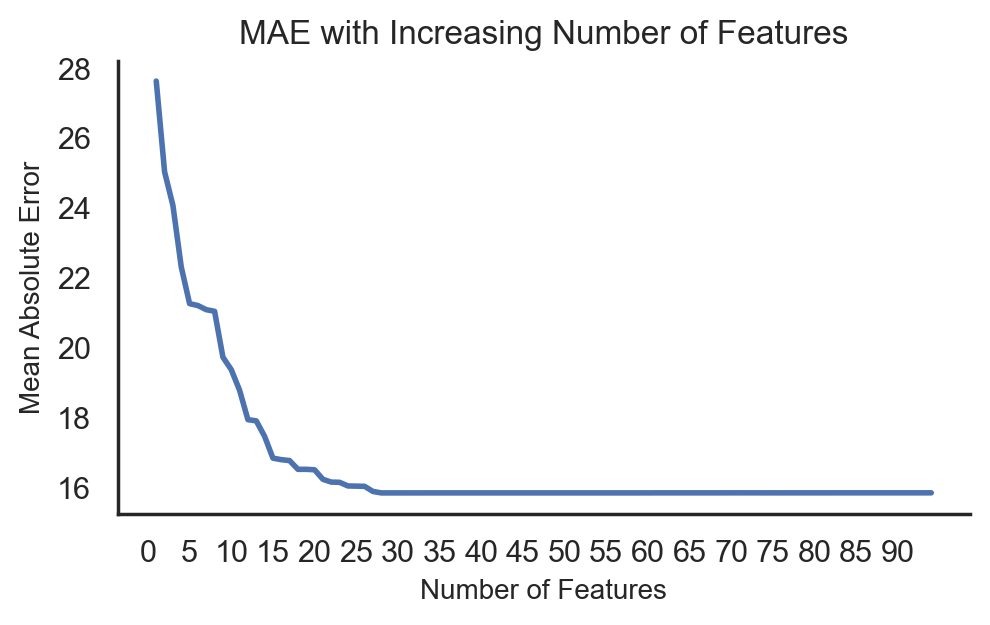

In [10]:
plt.rcParams['figure.dpi'] = 200
sns.set(style = "white")
fig, ax = plt.subplots(figsize = (7,3))
plt.plot(num_feat, mae_feat, linewidth = 2)
plt.xlabel('Number of Features', fontsize = 10)
plt.xticks(np.arange(0, max(num_feat), 5))
plt.ylabel('Mean Absolute Error', fontsize = 10)
plt.title('MAE with Increasing Number of Features', fontsize = 12)
sns.despine()
fig.set_size_inches(5.5,3)
plt.savefig('LinearNumFeatures.png', bbox_inches='tight');

We can see that we have a fast decline while we add a new feature until we reach 30 features where the reduction the MAE tapers off. What this means is that we can be confident that our model will perform just as well with only 28 features as the model would have with all 94.

What this means for the business is that we can save time and more importantly money. If we were to run this model on a paid server like AWS or Google Cloud, etc. we'd save money and time by only training on the 28 most important features and still get a model just as good.

In [11]:
data = {'Num_feat':num_feat,
        'Mae': mae_feat,}
lin_mae = pd.DataFrame(data)
lin_mae.loc[(lin_mae['Num_feat'] > 25) & (lin_mae['Num_feat'] < 35)]

,Num_feat,Mae
25,26,16.033172
26,27,15.886813
27,28,15.844379
28,29,15.844379
29,30,15.844379
30,31,15.844366
31,32,15.844436
32,33,15.844468
33,34,15.844763


In [41]:
selector = SelectKBest(f_regression, k = 28)
selector.fit(dum, target)
best_feat = dum.columns[selector.get_support(indices=True)].tolist()
scores = selector.scores_
d = {best_feat[i]: scores[i] for i in range(len(best_feat))}
best_feat_scores = sorted(d.items(), reverse=True, key = lambda x: x[1])
best_df = pd.DataFrame(best_feat_scores, columns = ['Feature','F-Score'])
best_df

,Feature,F-Score
0,yearsExperience,163648.828718
1,milesFromMetropolis,97233.115865
2,major_BIOLOGY,5.146978
3,jobType_SENIOR,2.697705
4,major_CHEMISTRY,2.457565
5,degree_MASTERS,2.341358
6,industry_WEB,2.068979
7,industry_SERVICE,1.765950
8,industry_FINANCE,1.128247
9,degree_NONE,1.011986


We can see that the most important features in predicting the salary that should be offered are years of experience and how close they live to the metropolis. This is pretty intuitive as a person with many years will make more than an entry level employee and larger companies are in the larger cities which allow for larger salaries.

### Lasso Regression

Lasso regression is a type of regularized regression that penalizes less important features more and makes them zero. Alpha is the magnitude of regularization on the coefficients. This is perfect for high dimensionality datasets.

To find the best alpha to use on the data I looped over the alpha values from .01 to .99. The larger the alpha the more the model is penalized.

In [19]:
lasso_pipe = make_pipeline(transformer, Lasso())
lasso = cross_val_score(lasso_pipe, feature_df, target, cv = 10, n_jobs = -1, scoring = 'neg_mean_absolute_error')
mae = -1 * np.mean(lasso)
std = np.std(lasso)
print(F"The 10-fold validation average MAE is {mae:.5f}, and the standard deviation is {std:.5f}")

The 10-fold validation average MAE is 17.88553, and the standard deviation is 0.05457


In [25]:
alpha = []
mae = []
for i in tqdm(range(1,100)):
    alpha.append(i/100)
    pipe = make_pipeline(transformer, Lasso(alpha = i/100))
    mae.append(-1*np.mean(cross_val_score(pipe, feature_df, target, 
        cv = 5, n_jobs = -1,scoring = 'neg_mean_absolute_error')))

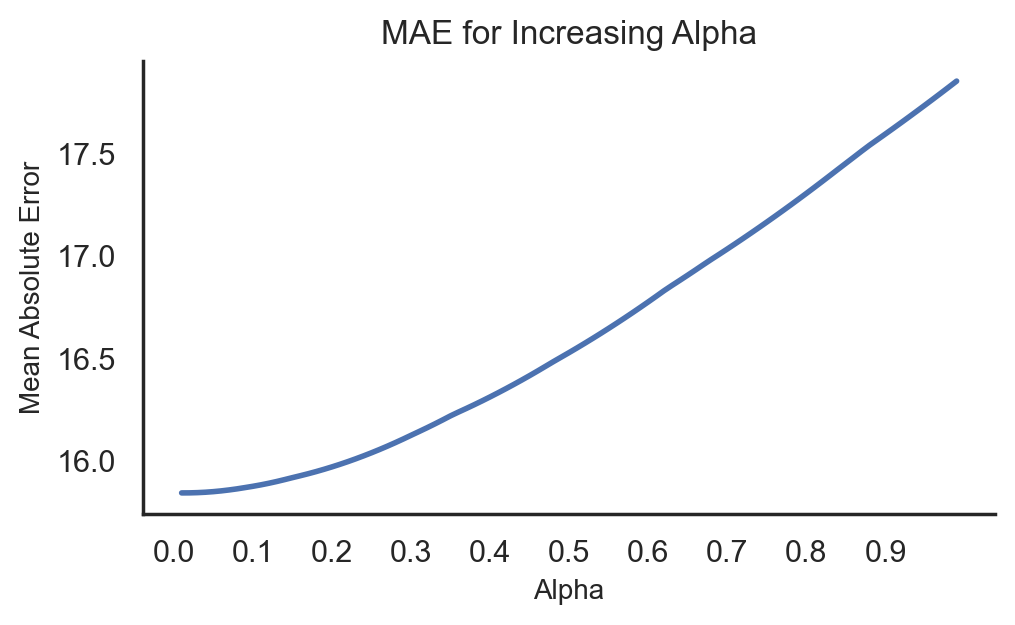

In [32]:
plt.rcParams['figure.dpi'] = 200
sns.set(style = "white")
fig, ax = plt.subplots(figsize = (7,3))
plt.plot(alpha, mae, linewidth = 2)
plt.xlabel('Alpha', fontsize = 10)
plt.xticks(np.arange(0, max(alpha), .1))
plt.ylabel('Mean Absolute Error', fontsize = 10)
plt.title('MAE for Increasing Alpha', fontsize = 12)
sns.despine()
fig.set_size_inches(5.5,3)
plt.savefig('LassoMAE.png', bbox_inches='tight');

In [33]:
lass = {'Alpha':alpha,
        'Mae': mae,}
lass_mae = pd.DataFrame(lass)
lass_mae.loc[(lass_mae['Alpha'] <.1)]

,Alpha,Mae
0,0.01,15.843854
1,0.02,15.844082
2,0.03,15.845187
3,0.04,15.847159
4,0.05,15.849996
5,0.06,15.853722
6,0.07,15.858331
7,0.08,15.863624
8,0.09,15.869791


What we see after graphing the MAE v. Alpha values is that the more penalized the model got the worse the MAE. We can also see that the Lasso Regression and Linear Regression are not much different at all.

### Gradient Boosting 
#### Effects of Early Stopping

Gradient boosting is combining weak "learners" into a single strong learner in an interative fashion using regression decision trees. This allows for generalization by allowing optimization of an arbitrary differentiable loss function.

Now what is early stopping? Like above using Select K Best in Linear Regression and adjusting Alpha in Lasso Regression, Early Stopping is a method to reduce model complexity. How early stopping works is if after i iterations the loss function does not reduce a tolerance t, then the model stops running.

For our situation, if the MAE does not reduce by tolerance t after i iterations (addition of i new weak learners) the model will stop running.

In [42]:
n_estimators = 1000
mae_gbes = []
est_gbes = []
mae_gb = []
est_gb = []


gbes = make_pipeline(transformer, GradientBoostingRegressor(n_estimators = n_estimators,
                                                            validation_fraction = .3,
                                                            loss='lad',
                                                            n_iter_no_change = 25,
                                                            tol = .001,
                                                            random_state = 6))

gb = make_pipeline(transformer, GradientBoostingRegressor(n_estimators = n_estimators,
                                                            loss='lad',
                                                            random_state = 6))

gbes.fit(feature_df, target)
gb.fit(feature_df,target)

mae_gbes.append(mean_absolute_error(target, gbes.predict(feature_df)))
mae_gb.append(mean_absolute_error(target, gb.predict(feature_df)))

est_gbes.append(gbes.named_steps['gradientboostingregressor'].n_estimators_)
est_gb.append(gb.named_steps['gradientboostingregressor'].n_estimators_)

print('Done')

Done


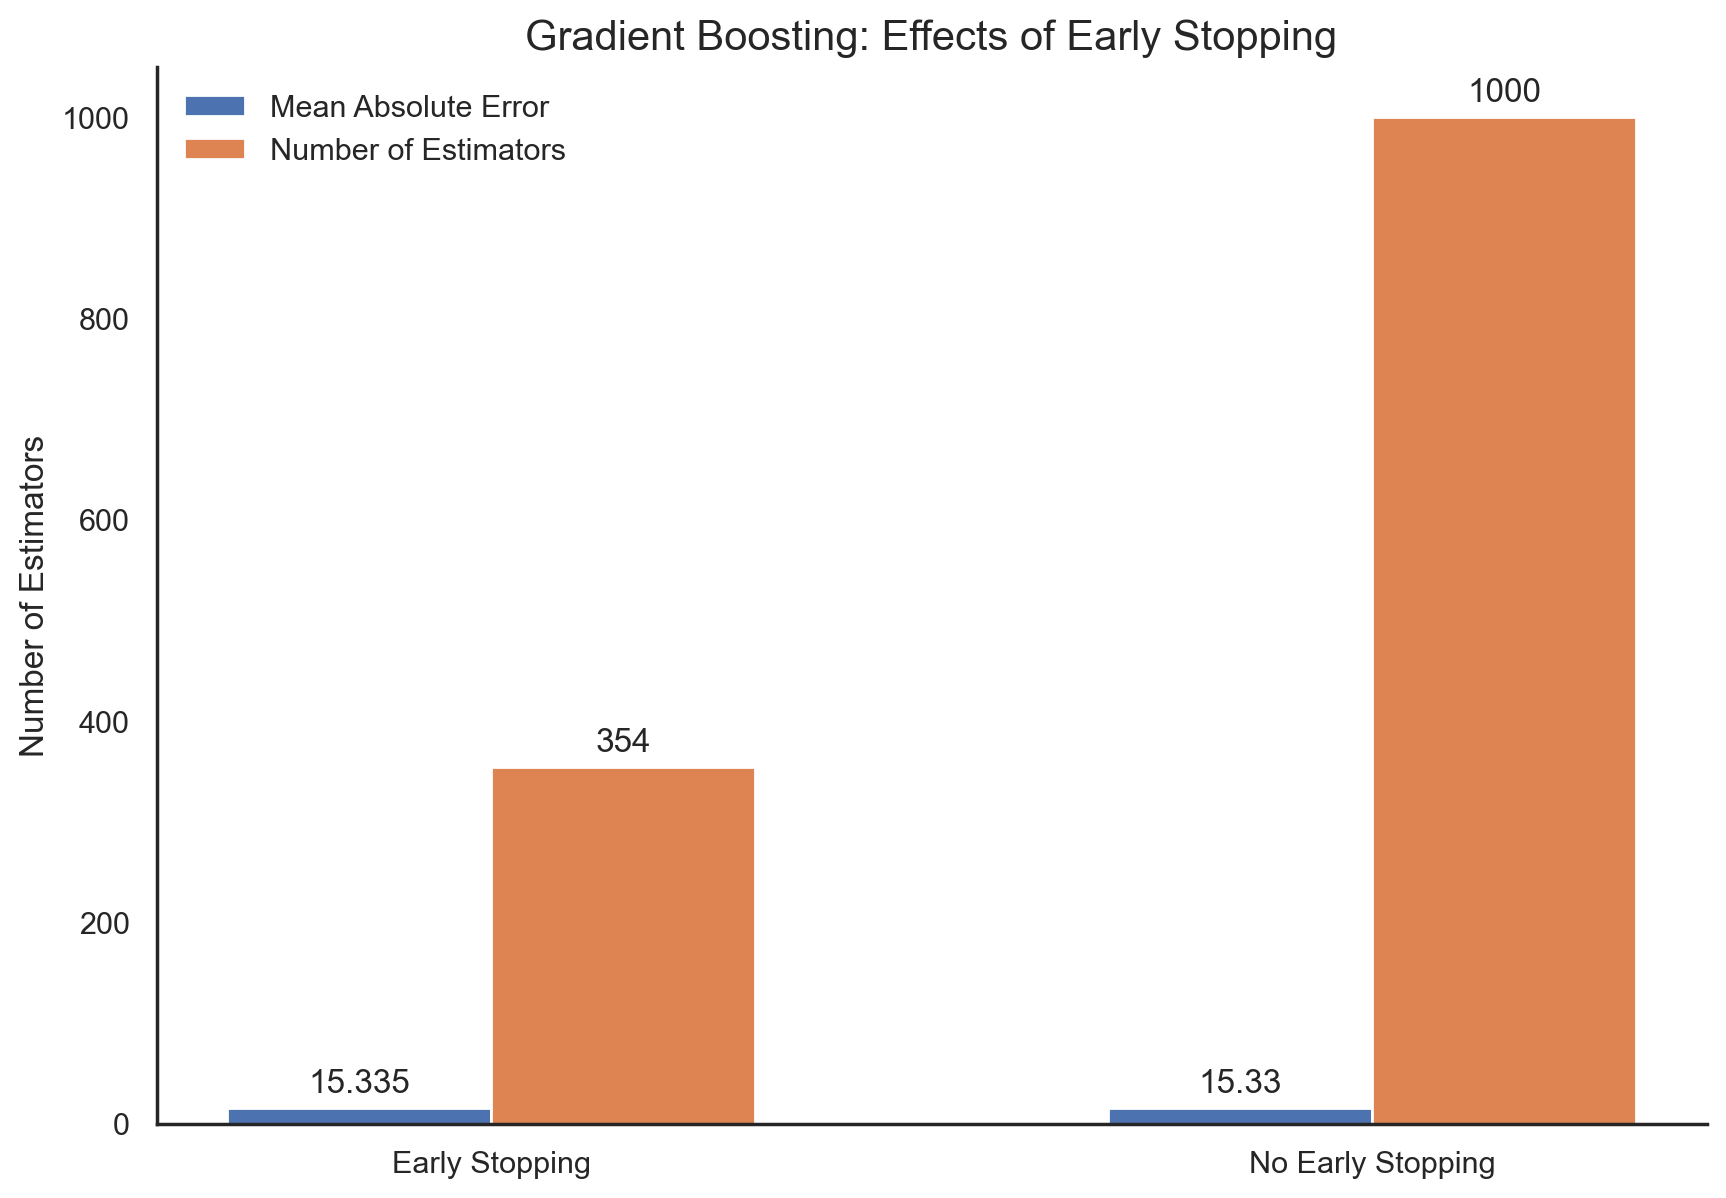

<Figure size 1200x800 with 0 Axes>

In [52]:
labels = ['Early Stopping','No Early Stopping']
dif_mae = [mae_gbes[0], mae_gb[0]]
estimators = [est_gbes[0] ,est_gb[0]]

x = np.arange(len(labels))
width = .3

plt.rcParams['figure.dpi'] = 200
sns.set(style = "white")
fig, ax = plt.subplots(figsize = (10,7))
bar1 = ax.bar(x - width/2, dif_mae, width, label = 'Mean Absolute Error')
bar2 = ax.bar(x + width/2, estimators, width, label = 'Number of Estimators')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Number of Estimators')
ax.set_title('Gradient Boosting: Effects of Early Stopping', fontsize = 15)
ax.legend(frameon = False)


def labeler(bars, list, rounding = 0):
    """
    Attaches a label above the bar
    """
    for bar in bars:
        height = bar.get_height()
        ax.annotate(F'{round(height, rounding)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
labeler(bar1, dif_mae, 3)
labeler(bar2, estimators)

sns.despine()
plt.show()
plt.savefig('EarlyStopping.png', bbox_inches='tight');

This chart shows the effects of early stopping for gradient boosting with our data. I set the number of iterations to 25 and the tolerance to .001. The iterations at 25 was just a personal preference but we could loop through a list of different number of stopping iterations if we wanted to be more thorough. I chose .001 for the tolerance as that is the thousandths decimal place.

What we are seeing is that the MAE is only .005 worse after stopping after 354 iterations compared to running the entire 1000 iterations. Thus, drastically reducing model complexity and effectively achieving the same result while saving money on run time.